## Evaluating ConcolicGrammarFuzzer

In this chapter, we will evaluate `ConcolicGrammarFuzzer`, which is our concolic fuzzer that uses grammars.

Our target will be a basic program that mimics an SQL database. We will fuzz this program using the `INVENTORY_GRAMMAR`, both with `ConcolicGrammarFuzzer` and `GrammarCoverageFuzzer`, then we will compare the success of these fuzzers. Namely, we will consider **line coverage**, **branch coverage** and **program depth** reached.

In [1]:
import fuzzingbook_utils

In [2]:
from ConcolicFuzzer import ConcolicGrammarFuzzer, ConcolicTracer
from GrammarCoverageFuzzer import GrammarCoverageFuzzer

## Target Program

In [3]:
from InformationFlow import INVENTORY_GRAMMAR, SQLException
from ConcolicFuzzer import ConcolicDB

INITIAL_DB = [
    (
        'vehicles',
        (
            {'year': int, 'kind': str, 'company': str, 'model': str},
            [
                {'year': 1997, 'kind': 'van', 'company': 'Ford', 'model': 'E350'},
                {'year': 2000, 'kind': 'car', 'company': 'Mercury', 'model': 'Cougar'},
                {'year': 1999, 'kind': 'car', 'company': 'Chevy', 'model': 'Venture'}
            ]
        )
    ),
    (
        'months',
        (
            {'month': int, 'name': str},
            [
                {'month': 1, 'name': 'jan'},
                {'month': 2, 'name': 'feb'},
                {'month': 3, 'name': 'mar'},
                {'month': 4, 'name': 'apr'},
                {'month': 5, 'name': 'may'},
                {'month': 6, 'name': 'jun'},
                {'month': 7, 'name': 'jul'},
                {'month': 8, 'name': 'aug'},
                {'month': 9, 'name': 'sep'},
                {'month': 10, 'name': 'oct'},
                {'month': 11, 'name': 'nov'},
                {'month': 12, 'name': 'dec'}
            ]
        )
    )
]

def db_select(query):
    global INITIAL_DB
    concolic_db = ConcolicDB()
    concolic_db.db = INITIAL_DB
    return concolic_db.sql(query)

## Coverage

In [4]:
import sys

class CoverageCollector:
    def __init__(self, functions=set()):
        self._traces = []
        self._coverage = set()
        self._branch_coverage = set()
        self._functions = functions
    
    def __enter__(self):
        self.original_tracer = sys.gettrace()
        sys.settrace(self._tracer)
        return self

    def __exit__(self, exc_type, exc_value, tb):
        sys.settrace(self.original_tracer)
        
    def _tracer(self, frame, event, arg):
        if self.original_tracer is not None:
            self.original_tracer(frame, event, arg)
            
        should_trace = (event == 'line' and 
                        frame.f_code.co_name in self._functions)
        
        if should_trace:
            function_name = frame.f_code.co_name
            line_no = frame.f_lineno
            trace = (function_name, line_no)
            
            if len(self._traces) > 0:
                last_trace = self._traces[-1]
                self._branch_coverage.add((last_trace, trace))
                
            self._traces.append(trace)
            self._coverage.add(trace)

        return self._tracer
    
    def get_traces(self):
        return self._traces

    def get_coverage(self):
        return self._coverage
    
    def get_branch_coverage(self):
        return self._branch_coverage

In [5]:
class Coverage:
    def __init__(self):
        self._line_coverage = set()
        self._branch_coverage = set()

    def update_coverage(self, coverage_collector):
        self._line_coverage |= coverage_collector.get_coverage()
        self._branch_coverage |= coverage_collector.get_branch_coverage()
    
    def get_line_coverage(self):
        line_dict = defaultdict(int)
        n_lines_covered = len(self._line_coverage)
        for func_name, line in self._line_coverage:
            line_dict[func_name] += 1
        return line_dict, n_lines_covered
    
    def get_branch_coverage(self):
        branch_dict = defaultdict(int)
        n_branches_covered = len(self._branch_coverage)
        for branch in self._branch_coverage:
            func_name = branch[0][0]
            branch_dict[func_name] += 1
        return branch_dict, n_branches_covered

## Runners

In [6]:
import time

In [7]:
def run_grammar_coverage_fuzzer(
        target, 
        grammar, 
        max_nonterminals,
        n_fuzz,
        functions): 
    
    gcf = GrammarCoverageFuzzer(grammar=grammar, 
                                max_nonterminals=max_nonterminals)
    
    coverage = Coverage()
    sql_exceptions = []
    other_exceptions = []
    
    start_time = time.time()
    
    for _ in range(n_fuzz):
        query = gcf.fuzz()
        with CoverageCollector(functions) as cov_collector:
            try:
                target(query)
            except SQLException as e:
                sql_exceptions.append(e)
            except Exception as e:
                other_exceptions.append(e)
        
        coverage.update_coverage(cov_collector)
    
    elapsed_time = time.time() - start_time
    
    return coverage, sql_exceptions, other_exceptions, elapsed_time

In [8]:
def run_concolic_grammar_fuzzer(
        target, 
        grammar, 
        max_nonterminals, 
        n_fuzz,
        functions):
    
    cgf = ConcolicGrammarFuzzer(grammar=grammar,
                                max_nonterminals=max_nonterminals)

    tokens_to_prune = ['<value>', '<table>', '<column>', 
                       '<literals>', '<exprs>', '<bexpr>']    
    cgf.prune_tokens(tokens_to_prune)
    
    coverage = Coverage()
    sql_exceptions = []
    other_exceptions = []
    
    start_time = time.time()

    for _ in range(n_fuzz):
        query = cgf.fuzz()
        with ConcolicTracer() as tracer, \
             CoverageCollector(functions) as cov_collector:
            try:
                tracer[target](query)
            except SQLException as e:
                sql_exceptions.append(e)
            except Exception as e:
                other_exceptions.append(e)
                
        cgf.update_grammar(tracer)
        coverage.update_coverage(cov_collector)

    elapsed_time = time.time() - start_time

    return coverage, sql_exceptions, other_exceptions, elapsed_time

## Fuzzing Configuration

In [9]:
N_FUZZ = 10
TARGET = db_select
GRAMMAR = INVENTORY_GRAMMAR
MAX_NONTERMINALS = 10
FUNCTIONS = {
    'sql', 
    'table',
    'do_update', 
    'do_insert', 
    'do_delete', 
    'db_select'
}

# Evaluation

## Comparative Run

In [10]:
from collections import defaultdict
import matplotlib.pyplot as plt
import numpy as np

def compare_coverage(ch1, name1, ch2, name2, functions):
    
    def print_plot_coverage(cov_dict1, total1, cov_dict2, total2, title):
        
        def print_coverage():
            print_format = '{0: <30} {1: <25} {2: <25}'
            print(print_format.format(title, name1, name2))
            print('-' * 80)
            print(print_format.format('all functions', total1, total2))
            for f in functions:
                print(print_format.format(f, cov_dict1[f], cov_dict2[f]))

        def plot_coverage():
            x_indexes = [i for i in range(len(functions) + 1)]
            x_labels = ['all functions'] + list(functions)

            plt.title(title)
            plt.bar([x-0.1 for x in x_indexes], 
                    [total1] + [cov_dict1[f] for f in functions],  
                    width=0.2, align='center', label=name1)

            plt.bar([x+0.1 for x in x_indexes], 
                    [total2] + [cov_dict2[f] for f in functions],  
                    width=0.2, align='center', label=name2)

            plt.legend(loc='upper right')
            plt.xticks(x_indexes, x_labels, rotation=20)
            plt.show()
            
        print_coverage()
        plot_coverage()
    
    def compare_line_coverage():
        print_plot_coverage(*ch1.get_line_coverage(),
                            *ch2.get_line_coverage(),
                            'Line Coverage')
        
    
    def compare_branch_coverage():
        print_plot_coverage(*ch1.get_branch_coverage(),
                            *ch2.get_branch_coverage(),
                            'Branch Coverage')
        
    compare_line_coverage()
    compare_branch_coverage()

def compare_exceptions(sql1, other1, name1, sql2, other2, name2):
    print_format = '{0: <30} {1: <25} {2: <25}'
    print(print_format.format('Exception Type', name1, name2))
    print('-' * 80)
    print(print_format.format('sql', len(sql1), len(sql2)))
    print(print_format.format('other', len(other1), len(other2)))

def compare_elapsed_time(t1, name1, t2, name2):
    print_format = '{0: <30} {1: <25} {2: <25}'
    print(print_format.format('', name1, name2))
    print('-' * 80)
    print(print_format.format('Elapsed Time (s)', round(t1, 2), round(t2, 2)))
    x_indexes = [0, 1]
    x_labels = [name1, name2]
    plt.title('Elapsed Time (s)')
    plt.bar(0, t1, width=0.2, align='center', label=name1)
    plt.bar(0.2, t2, width=0.2, align='center', label=name2)
    plt.xticks(np.arange(0, 1, 0.2), x_labels, rotation=20)
    plt.legend(loc='upper right')
    plt.show()
        
def comperative_run(target, grammar, max_nonterminals, n_fuzz, functions):
    cov1, sql1, other1, t1 = run_concolic_grammar_fuzzer(
        target=target, 
        grammar=grammar, 
        max_nonterminals=max_nonterminals, 
        n_fuzz=n_fuzz,
        functions=functions
    )
    
    cov2, sql2, other2, t2 = run_grammar_coverage_fuzzer(
        target=target, 
        grammar=grammar, 
        max_nonterminals=max_nonterminals, 
        n_fuzz=n_fuzz,
        functions=functions
    )

    compare_coverage(cov1, 'ConcolicGrammarFuzzer',
                     cov2, 'GrammarCoverageFuzzer',
                     functions)
        
    compare_elapsed_time(t1, 'ConcolicGrammarFuzzer',
                         t2, 'GrammarCoverageFuzzer')
    
    compare_exceptions(sql1, other1, 'ConcolicGrammarFuzzer',
                       sql2, other2, 'GrammarCoverageFuzzer')

Line Coverage                  ConcolicGrammarFuzzer     GrammarCoverageFuzzer    
--------------------------------------------------------------------------------
all functions                  56                        29                       
sql                            7                         7                        
table                          4                         3                        
do_update                      16                        6                        
do_insert                      15                        5                        
do_delete                      11                        5                        
db_select                      3                         3                        


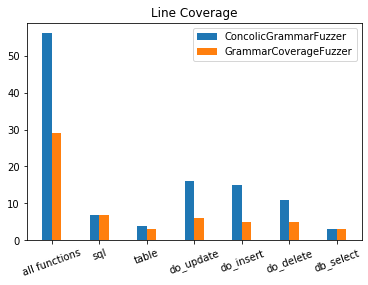

Branch Coverage                ConcolicGrammarFuzzer     GrammarCoverageFuzzer    
--------------------------------------------------------------------------------
all functions                  63                        33                       
sql                            11                        11                       
table                          7                         3                        
do_update                      16                        6                        
do_insert                      15                        5                        
do_delete                      11                        5                        
db_select                      3                         3                        


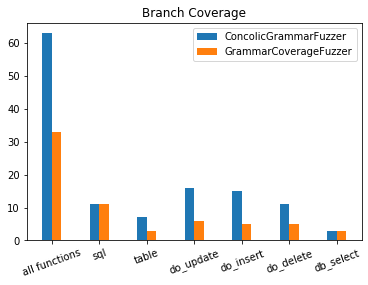

                               ConcolicGrammarFuzzer     GrammarCoverageFuzzer    
--------------------------------------------------------------------------------
Elapsed Time (s)               7.55                      60.9                     


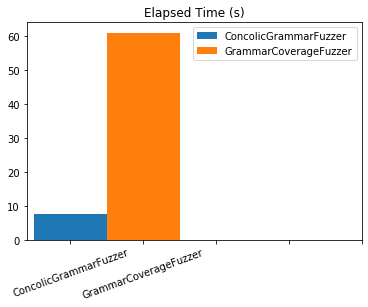

Exception Type                 ConcolicGrammarFuzzer     GrammarCoverageFuzzer    
--------------------------------------------------------------------------------
sql                            94                        100                      
other                          1                         0                        


In [11]:
comperative_run(
    target=TARGET, 
    grammar=GRAMMAR, 
    max_nonterminals=MAX_NONTERMINALS, 
    n_fuzz=100,
    functions=FUNCTIONS
)

## Solo Run

In [12]:
def solo_run(target, grammar, max_nonterminals, n_fuzz, functions, runner, name):
    def print_plot_coverage(cov_dict, total, title): 
        def print_coverage():
            print_format = '{0: <40} {1}'
            print(print_format.format(title, name))
            print('-' * 80)
            print(print_format.format('all functions', total))
            for f in functions:
                print(print_format.format(f, cov_dict[f]))

        def plot_coverage():
            x_indexes = [i for i in range(len(functions) + 1)]
            x_labels = ['all functions'] + list(functions)

            plt.title(title)
            plt.bar(x_indexes, 
                    [total] + [cov_dict[f] for f in functions],  
                    width=0.2, align='center', label=name)

            plt.legend(loc='upper right')
            plt.xticks(x_indexes, x_labels, rotation=20)
            plt.show()
        
        print_coverage()
        plot_coverage()
   
    def print_exceptions(sql_exceptions, other_exceptions):
        print_format = '{0: <40} {1}'
        print('-' * 80)
        print(print_format.format('Exception Type', 'Number of Occurrences'))
        print('-' * 80)
        print(print_format.format('SQLException', len(sql_exceptions)))
        print(print_format.format('Other', len(other_exceptions)))    

    cov, sql, other, t = runner(
        target=target, 
        grammar=grammar, 
        max_nonterminals=max_nonterminals, 
        n_fuzz=n_fuzz,
        functions=functions
    )
    
    print_plot_coverage(*cov.get_line_coverage(),
                        'Line Coverage')
    
    print_plot_coverage(*cov.get_branch_coverage(),
                        'Branch Coverage')
    
    print_exceptions(sql, other)

Line Coverage                            ConcolicGrammarFuzzer
--------------------------------------------------------------------------------
all functions                            35
sql                                      7
table                                    4
do_update                                14
do_insert                                0
do_delete                                7
db_select                                3


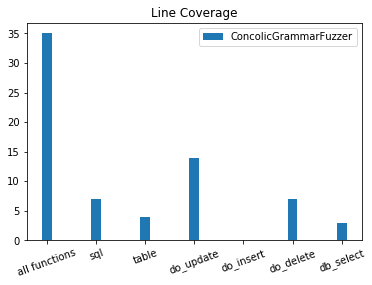

Branch Coverage                          ConcolicGrammarFuzzer
--------------------------------------------------------------------------------
all functions                            38
sql                                      10
table                                    6
do_update                                13
do_insert                                0
do_delete                                6
db_select                                3


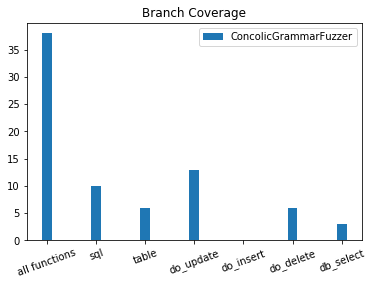

--------------------------------------------------------------------------------
Exception Type                           Number of Occurrences
--------------------------------------------------------------------------------
SQLException                             7
Other                                    0


In [13]:
solo_run(
    target=TARGET, 
    grammar=GRAMMAR, 
    max_nonterminals=MAX_NONTERMINALS, 
    n_fuzz=10,
    functions=FUNCTIONS,
    runner=run_concolic_grammar_fuzzer,
    name='ConcolicGrammarFuzzer'
)

Line Coverage                            GrammarCoverageFuzzer
--------------------------------------------------------------------------------
all functions                            29
sql                                      7
table                                    3
do_update                                6
do_insert                                5
do_delete                                5
db_select                                3


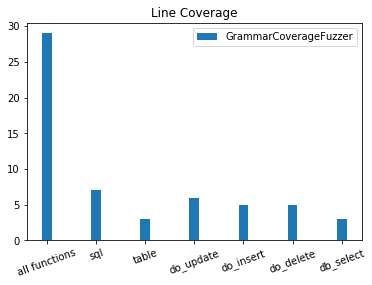

Branch Coverage                          GrammarCoverageFuzzer
--------------------------------------------------------------------------------
all functions                            33
sql                                      11
table                                    3
do_update                                6
do_insert                                5
do_delete                                5
db_select                                3


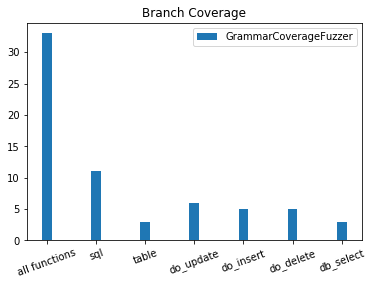

--------------------------------------------------------------------------------
Exception Type                           Number of Occurrences
--------------------------------------------------------------------------------
SQLException                             10
Other                                    0


In [14]:
solo_run(
    target=TARGET, 
    grammar=GRAMMAR, 
    max_nonterminals=MAX_NONTERMINALS, 
    n_fuzz=10,
    functions=FUNCTIONS,
    runner=run_grammar_coverage_fuzzer,
    name='GrammarCoverageFuzzer'
)